## Kelmarsh Wind Farm Data

Assumptions:
- Dataset: [Kelmarsh Wind Farm Data](https://zenodo.org/record/7212475)  
- Turbine №5 is used for analysis
- Train data: [2019.01.01 - 2021.03.26]  
- Validation: [2021.03.27 - 2021.03.31]  
- Demo data: [2021.04.01 - 2021.06.30]  
- ERA5 weather data taken as historical weather forecasts
- The turbine forced downtime is known in advance

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme(style="darkgrid", font_scale=0.8)

### Turbine SCADA Data

There is over 300 variables from SCADA system in the dataset. Since we want to forecast power day-ahead, we cannot use direct sensors data as exogenous variables due to future information leakage. 

The only additional variable we can use here is 'Long Term Wind (m/s)' which is monthly average wind speed data.

In [2]:
filenames = [
    '../data/Turbine_Data_Kelmarsh_5_2019-01-01_-_2020-01-01_232.csv',
    '../data/Turbine_Data_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv',
    '../data/Turbine_Data_Kelmarsh_5_2021-01-01_-_2021-07-01_232.csv']

cols_use = ['# Date and time', 'Long Term Wind (m/s)', 'Power (kW)']

df = pd.concat((pd.read_csv(file, 
                            header=9,
                            index_col=['# Date and time'],
                            parse_dates=True,
                            infer_datetime_format=True,
                            usecols=cols_use)
               ) for file in filenames)
df.index.freq = df.index.inferred_freq
df.index.names = ['dt']
df.columns = ['long_term_wind', 'power']
df.head()

,long_term_wind,power
dt,,
2019-01-01 00:00:00,7.1,270.857422
2019-01-01 00:10:00,7.1,337.457855
2019-01-01 00:20:00,7.1,349.862000
2019-01-01 00:30:00,7.1,349.753662
2019-01-01 00:40:00,7.1,48.554565


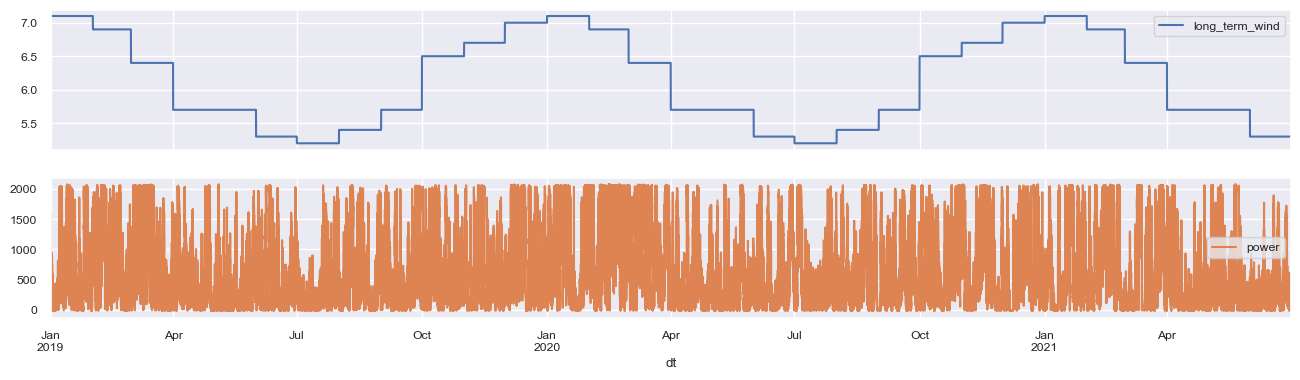

In [3]:
df.plot(subplots=True, figsize=(16,4))
plt.show()

In [4]:
df.describe()

,long_term_wind,power
count,131328.00000,130718.000000
mean,6.14068,611.696285
std,0.67301,635.696317
min,5.20000,-21.170280
25%,5.70000,107.106860
50%,5.70000,365.592692
75%,6.90000,946.537062
max,7.10000,2081.809985


In [5]:
df.isna().sum()

long_term_wind      0
power             610
dtype: int64

In [6]:
# Interpolate missing data using linear method
df = df.interpolate(method='linear')
df.isna().sum()

long_term_wind    0
power             0
dtype: int64

In [7]:
# Clip power to 0 - 2050 kW nominal output range for model simplicity.
# Modelling active/reactive power flows of asynchronous generator is out of the scope of this project.
df.power = df.power.clip(0, 2050)

### Turbine Status Data

During the operation of turbine, there come times when the turbine is stopped due to technical standby, scheduled maintenance and other kinds of forced outages. 

This events should be labeled to properly train our machine learning model.

In [8]:
filenames = [
    '../data/Status_Kelmarsh_5_2019-01-01_-_2020-01-01_232.csv',
    '../data/Status_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv',
    '../data/Status_Kelmarsh_5_2021-01-01_-_2021-07-01_232.csv']

df_status = pd.concat(((pd.read_csv(file, 
                                    header=9,
                                    na_values='-',
                                    parse_dates=['Timestamp start', 'Timestamp end'],
                                    infer_datetime_format=True)
                       ) for file in filenames), ignore_index=True)
df_status.head()

,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,2019-01-01 11:47:52,2019-01-01 11:50:10,00:02:18,Stop,710,Battery test,NaN,Operating states (28),Technical Standby
1,2019-01-01 11:47:52,NaT,NaN,Informational,100030,Brake program 180,NaN,NaN,Technical Standby
2,2019-01-01 11:50:10,NaT,NaN,Informational,0,System OK,NaN,System OK (32),Full Performance
3,2019-01-01 11:50:10,NaT,NaN,Informational,100110,Bypass limit switches,NaN,NaN,Full Performance
4,2019-01-01 11:50:15,NaT,NaN,Informational,100130,Automatic start-up,NaN,NaN,Full Performance


In [9]:
df_status = df_status[df_status['Status'] == 'Stop']
df_status = df_status[['Timestamp start', 'Timestamp end']]
df_status.columns = ['start', 'end']
df_status

,start,end
0,2019-01-01 11:47:52,2019-01-01 11:50:10
176,2019-01-08 11:47:41,2019-01-08 11:49:59
188,2019-01-10 13:04:54,2019-01-10 13:50:40
213,2019-01-16 08:31:02,2019-01-16 10:17:00
224,2019-01-17 13:43:32,2019-01-17 13:45:50
...,...,...
23804,2021-06-17 14:05:38,2021-06-17 14:17:43
23824,2021-06-22 11:46:41,2021-06-22 11:48:59
23861,2021-06-23 17:20:25,2021-06-23 17:30:26
23869,2021-06-24 06:56:45,2021-06-24 07:16:38


In [10]:
df['status_stop'] = 0

for event in df_status.itertuples(index=False):
    df.loc[event.start:event.end, 'status_stop'] = 1

In [11]:
df[df['status_stop'] == 1]

,long_term_wind,power,status_stop
dt,,,
2019-01-01 11:50:00,7.1,266.153046,1
2019-01-10 13:10:00,7.1,36.509748,1
2019-01-10 13:20:00,7.1,22.081622,1
2019-01-10 13:30:00,7.1,7.653497,1
2019-01-10 13:40:00,7.1,0.000000,1
...,...,...,...
2021-06-23 17:30:00,5.3,0.000000,1
2021-06-24 07:00:00,5.3,5.573334,1
2021-06-24 07:10:00,5.3,0.000000,1


### ERA5 Weather Data

ERA5 provides hourly estimates of climate data on a 30x30km land grid. We will use it as a simulation of day-ahead weather forecast data.

*(Ideally, the historical weather forecast data should be used as exogenous variables, but I was not succesfull to find this data in open access)*

In [11]:
era5 = pd.read_csv('../data/Kelmarsh_era5.csv', index_col=['datetime'], parse_dates=True, infer_datetime_format=True)
era5 = era5['2019-01-01 00:00:00':'2021-07-01 00:00:00']
era5.head()

,u_ms,v_ms,temperature_K,surf_pres_Pa,windspeed_ms,winddirection_deg,rho_kgm-3
datetime,,,,,,,
2019-01-01 00:00:00,8.1875,0.1875,280.1875,101886.156250,8.189647,268.688112,1.264451
2019-01-01 01:00:00,8.1875,-0.5000,280.2500,101870.234375,8.202753,273.494639,1.263962
2019-01-01 02:00:00,8.0000,-0.8125,280.4375,101870.578125,8.041154,275.799218,1.263093
2019-01-01 03:00:00,8.2500,-0.9375,280.5000,101871.906250,8.303096,276.483074,1.262818
2019-01-01 04:00:00,8.3125,-1.3125,280.5625,101856.078125,8.415481,278.972627,1.262331


In [12]:
# Directional data in degrees 0-360 is not smooth, which is not well suited for machine learning algorithms
# Transform degrees to sin and cos components:
era5['winddirection_sin'] = np.sin(np.deg2rad(era5.winddirection_deg))
era5['winddirection_cos'] = np.cos(np.deg2rad(era5.winddirection_deg))

# U and V wind components data is redundant, since the direction is known
era5 = era5.drop(['u_ms', 'v_ms', 'winddirection_deg'], axis=1)

# Resample to target frequency
era5 = era5.resample('10T').interpolate(method='linear').drop('2021-07-01 00:00:00')
era5.tail()

,temperature_K,surf_pres_Pa,windspeed_ms,rho_kgm-3,winddirection_sin,winddirection_cos
datetime,,,,,,
2021-06-30 23:10:00,285.572917,100426.278646,1.655305,1.221862,0.427997,0.903076
2021-06-30 23:20:00,285.458333,100428.869792,1.800230,1.222408,0.442190,0.895785
2021-06-30 23:30:00,285.343750,100431.460938,1.945155,1.222954,0.456384,0.888494
2021-06-30 23:40:00,285.229167,100434.052083,2.090080,1.223499,0.470577,0.881204
2021-06-30 23:50:00,285.114583,100436.643229,2.235004,1.224045,0.484771,0.873913


In [13]:
era5.describe()

,temperature_K,surf_pres_Pa,windspeed_ms,rho_kgm-3,winddirection_sin,winddirection_cos
count,131328.000000,131328.000000,131328.000000,131328.000000,131328.000000,131328.000000
mean,283.088315,99987.254176,7.396921,1.227989,-0.248007,-0.100696
std,5.861771,1217.283102,3.349570,0.030103,0.694287,0.663787
min,267.812500,95606.937500,0.088388,1.107726,-1.000000,-1.000000
25%,278.916667,99223.296875,5.055750,1.206380,-0.867457,-0.724006
50%,282.583333,100127.818359,7.073467,1.226001,-0.510758,-0.200746
75%,287.020833,100831.590820,9.370143,1.248982,0.411618,0.523806
max,309.062500,103373.718750,23.693436,1.317750,1.000000,1.000000


### Exploratory Data Analysis (EDA)

In [14]:
df = pd.concat([df, era5], axis=1)
df

,long_term_wind,power,status_stop,temperature_K,surf_pres_Pa,windspeed_ms,rho_kgm-3,winddirection_sin,winddirection_cos
2019-01-01 00:00:00,7.1,270.857422,0,280.187500,101886.156250,8.189647,1.264451,-0.999738,-0.022895
2019-01-01 00:10:00,7.1,337.457855,0,280.197917,101883.502604,8.191831,1.264369,-0.999472,-0.008920
2019-01-01 00:20:00,7.1,349.862000,0,280.208333,101880.848958,8.194015,1.264288,-0.999205,0.005055
2019-01-01 00:30:00,7.1,349.753662,0,280.218750,101878.195312,8.196200,1.264206,-0.998939,0.019030
2019-01-01 00:40:00,7.1,48.554565,0,280.229167,101875.541667,8.198384,1.264125,-0.998673,0.033005
...,...,...,...,...,...,...,...,...,...
2021-06-30 23:10:00,5.3,76.690002,0,285.572917,100426.278646,1.655305,1.221862,0.427997,0.903076
2021-06-30 23:20:00,5.3,112.709999,0,285.458333,100428.869792,1.800230,1.222408,0.442190,0.895785
2021-06-30 23:30:00,5.3,91.540001,0,285.343750,100431.460938,1.945155,1.222954,0.456384,0.888494
2021-06-30 23:40:00,5.3,53.139999,0,285.229167,100434.052083,2.090080,1.223499,0.470577,0.881204


In [15]:
# To speed up notebook restarts
df.to_pickle('../data/df.pkl')
df = pd.read_pickle('../data/df.pkl')

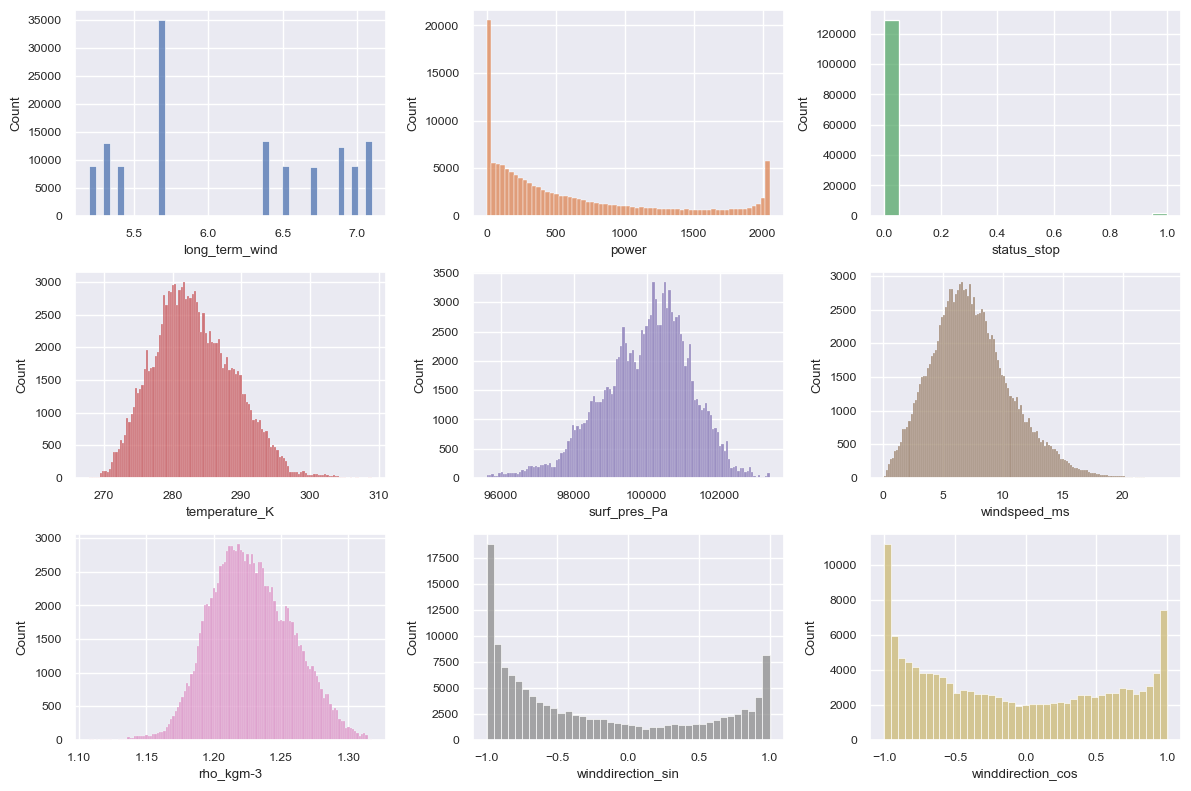

In [16]:
palette = sns.color_palette()
fig, axs = plt.subplots(3, 3, figsize=(12,8))

for x, ax, color in zip(df.columns, axs.flat, palette):
    sns.histplot(data=df, x=x, color=color, ax=ax, legend=True)

plt.tight_layout()
plt.show()

### Turbine Power Curve

In [17]:
import mpl_scatter_density
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=LogStretch())

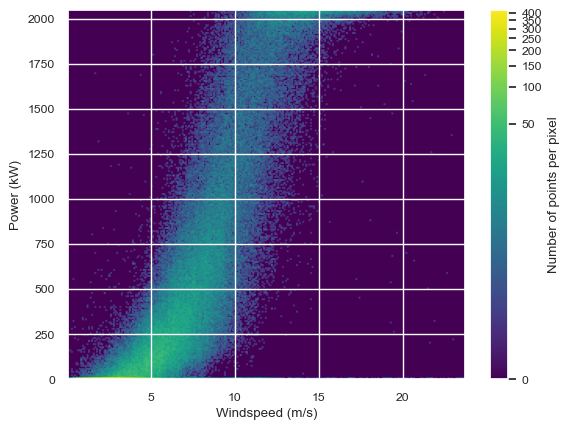

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='scatter_density', xlabel='Windspeed (m/s)', ylabel='Power (kW)')
density = ax.scatter_density(df.windspeed_ms, df.power, norm=norm, cmap="viridis")
fig.colorbar(density, label='Number of points per pixel')
plt.show()

## sktime

First, let's start with models that use only the power time series data itself. Forecasters evaluation will be done through backtesting (temporal cross-validation).

In [19]:
from sktime.forecasting.model_selection import temporal_train_test_split, ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredPercentageError, MeanAbsoluteError, MeanSquaredError
from sktime.utils.plotting import plot_series

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [20]:
# Data up to '2021-03-31 23:50:00' will be used for training and validation, the rest is for the demo unit
y = df.loc[:'2021-03-31 23:50:00', ['power']]
X = df.loc[:'2021-03-31 23:50:00'].drop('power', axis=1)

In [21]:
# Forecasting horizon is 144 intervals (10min) ahead, which equals 1 day.
fh = ForecastingHorizon(np.arange(1, 145), is_relative=True)

In [22]:
# Backtesting on the last 5 days
cv = ExpandingWindowSplitter(fh=fh, initial_window=len(y)-5*144, step_length=144)

In [23]:
# Loss functions
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

### Naive Forecaster

In [24]:
naive = NaiveForecaster()

results = evaluate(forecaster=naive, cv=cv, y=y, strategy='update', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,531.578532,0.002871,0.054544,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00:...
1,70.749647,0.011442,0.041947,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00:...
2,836.620245,0.012808,0.048797,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,612.845207,0.014392,0.051104,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00:...
4,285.279808,0.012473,0.048275,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [25]:
results.test_MeanSquaredError.mean()

467.41468802409025

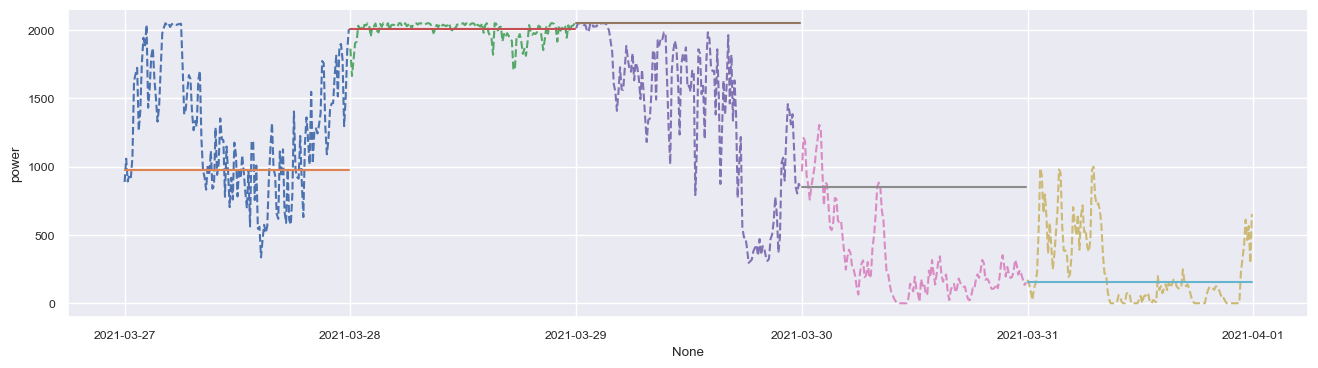

In [26]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [27]:
naive.fit(y=y, X=X)
naive.save('../models/naive')

<zipfile.ZipFile filename='..\\models\\naive.zip' mode='r'>

### Linear Regression

In [28]:
linear_pipe = ForecastingPipeline(steps=[
    ("scaler", TabularToSeriesAdaptor(StandardScaler())), 
    ("forecaster", make_reduction(LinearRegression()))
])

In [29]:
results = evaluate(forecaster=linear_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,442.844023,2.008884,0.049139,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,292.404257,2.181465,0.047837,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,387.361354,2.067198,0.058788,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,204.937952,1.970389,0.041214,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00:...
4,241.571107,1.946924,0.117172,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [30]:
results.test_MeanSquaredError.mean()

313.8237383371074

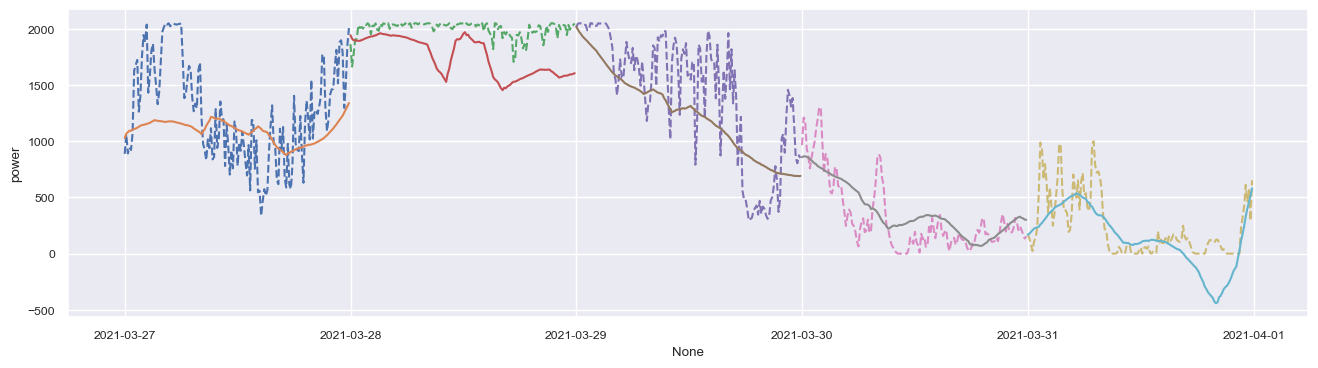

In [31]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [32]:
linear_pipe.fit(y=y, X=X)
linear_pipe.save('../models/linear_pipe')

<zipfile.ZipFile filename='..\\models\\linear_pipe.zip' mode='r'>

### Lasso Regression

In [33]:
lasso_pipe = ForecastingPipeline(steps=[
    ("scaler", TabularToSeriesAdaptor(StandardScaler())), 
    ("forecaster", make_reduction(Lasso()))
])

In [34]:
results = evaluate(forecaster=lasso_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,442.726478,11.069182,0.036319,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,305.457545,6.079067,0.035631,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,387.548967,6.122886,0.041264,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,208.582767,6.398676,0.044420,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00:...
4,214.098602,17.604436,0.105526,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [35]:
results.test_MeanSquaredError.mean()

311.6828717466473

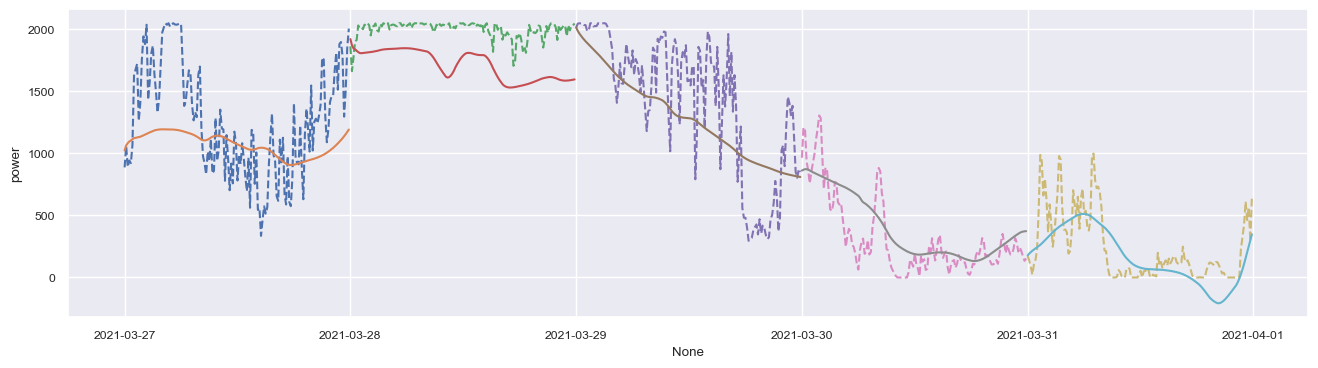

In [36]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [37]:
lasso_pipe.fit(y=y, X=X)
lasso_pipe.save('../models/lasso_pipe')

<zipfile.ZipFile filename='..\\models\\lasso_pipe.zip' mode='r'>

### KNN Regression

In [38]:
knn_pipe = ForecastingPipeline(steps=[
    ("scaler", TabularToSeriesAdaptor(StandardScaler())), 
    ("forecaster", make_reduction(KNeighborsRegressor(n_neighbors=7)))
])

In [39]:
results = evaluate(forecaster=knn_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,616.231904,0.264830,2.308533,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,936.678702,0.255251,1.697247,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,406.168017,0.252585,1.733028,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,581.127556,0.239831,1.700278,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00...
4,297.395998,0.251759,1.687931,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [40]:
results.test_MeanSquaredError.mean()

567.5204355164487

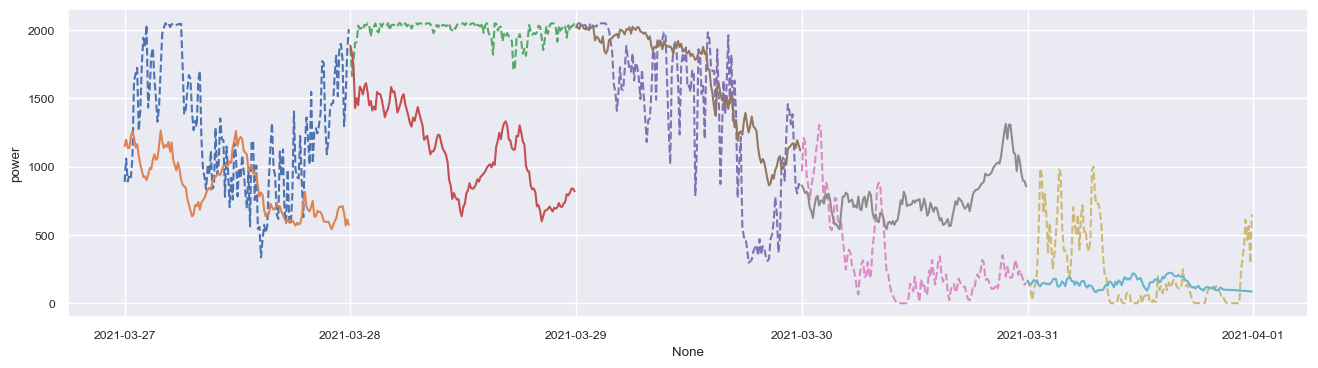

In [41]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [42]:
knn_pipe.fit(y=y, X=X)
knn_pipe.save('../models/knn_pipe')

<zipfile.ZipFile filename='..\\models\\knn_pipe.zip' mode='r'>

### Decision Tree

In [43]:
tree = make_reduction(DecisionTreeRegressor())

In [44]:
results = evaluate(forecaster=tree, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,612.562060,50.366116,0.098987,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,145.154770,54.766903,0.076560,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,534.066147,36.437966,0.057171,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,324.317415,36.214469,0.027474,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00...
4,266.970401,70.401630,0.030194,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00...


In [45]:
results.test_MeanSquaredError.mean()

376.6141586066668

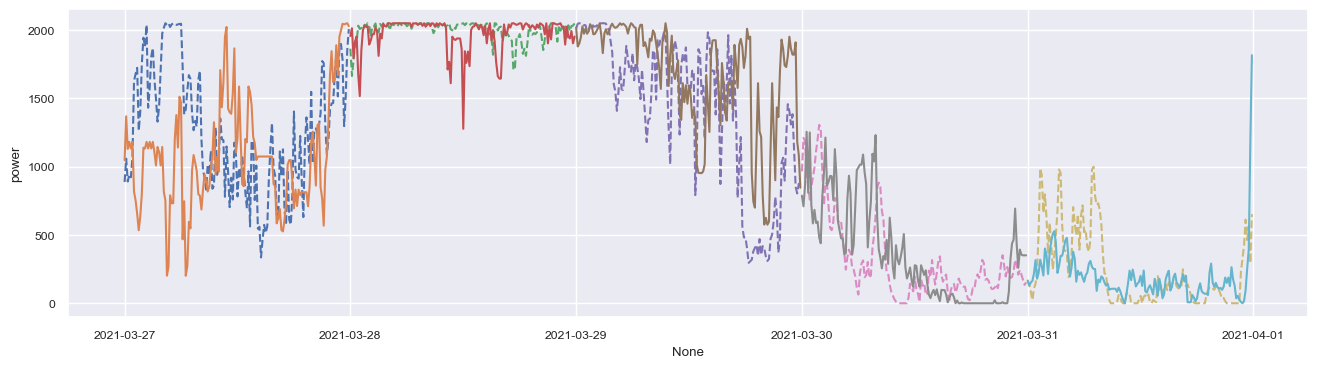

In [46]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [47]:
tree.fit(y=y, X=X)
tree.save('../models/tree')

<zipfile.ZipFile filename='..\\models\\tree.zip' mode='r'>

### Random Forest

In [49]:
forest = make_reduction(RandomForestRegressor(n_estimators=5))

In [50]:
results = evaluate(forecaster=forest, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,411.747981,101.211097,0.274794,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,226.052932,89.736073,0.067654,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,359.525340,79.683332,0.062538,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,191.118359,77.061763,0.064852,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00...
4,235.475362,78.546506,0.061920,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00...


In [51]:
results.test_MeanSquaredError.mean()

284.7839949920141

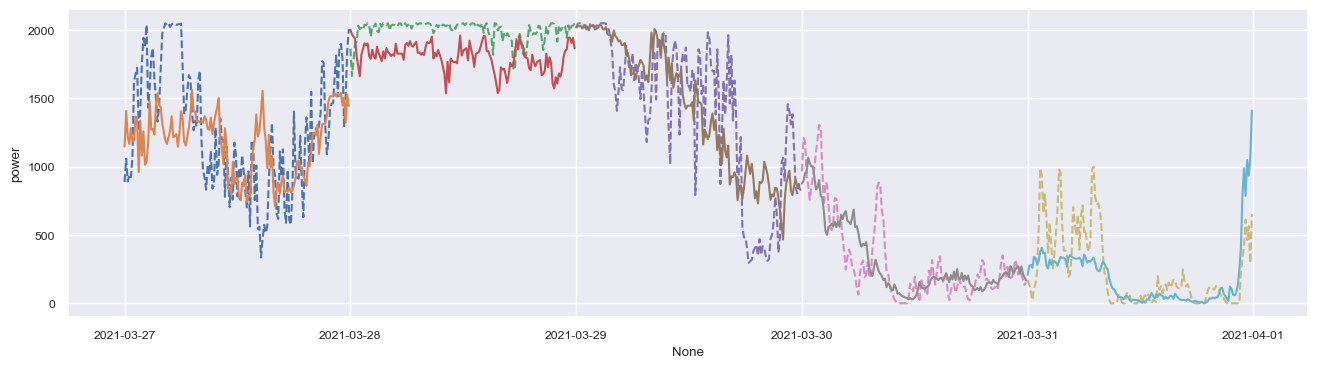

In [52]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [53]:
forest.fit(y=y, X=X)
forest.save('../models/forest')

<zipfile.ZipFile filename='..\\models\\forest.zip' mode='r'>

### LightGBM

In [54]:
from lightgbm import LGBMRegressor

In [55]:
lgbm = make_reduction(LGBMRegressor(objective='regression', metric='rmse'), scitype="tabular-regressor")

In [56]:
results = evaluate(forecaster=lgbm, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17980
[LightGBM] [Info] Number of data points in the train set: 117494, number of used features: 90
[LightGBM] [Info] Start training from score 632.103114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17980
[LightGBM] [Info] Number of data points in the train set: 117638, number of used features: 90
[LightGBM] [Info] Start training from score 632.876258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17980
[LightGBM] [Info] Number of data points in the 

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,342.058320,3.124768,0.089637,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,136.343324,3.408147,0.100490,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,333.452789,2.894897,0.097174,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,196.182062,3.015771,0.099431,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00:...
4,216.752199,3.170742,0.090338,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [57]:
results.test_MeanSquaredError.mean()

244.95773895096232

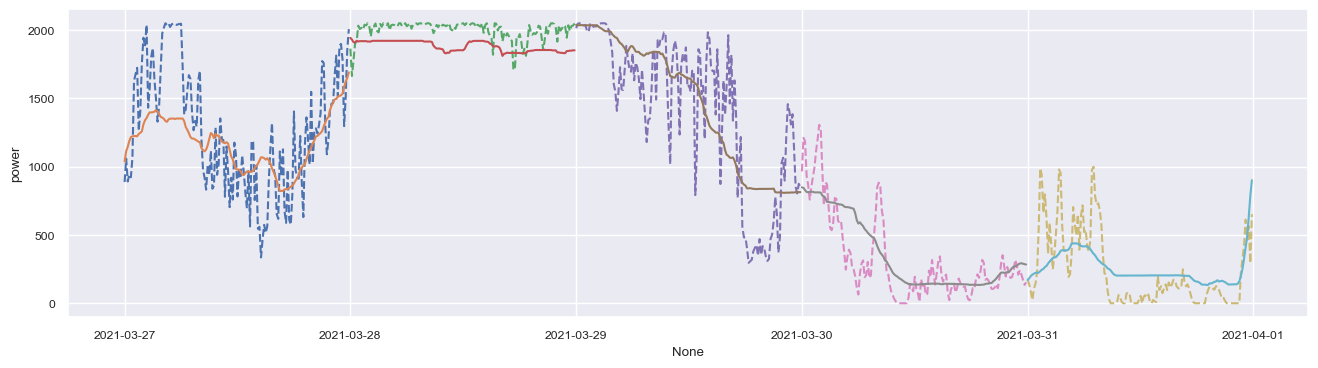

In [58]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [59]:
lgbm.fit(y=y, X=X)
lgbm.save('../models/lgbm')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17980
[LightGBM] [Info] Number of data points in the train set: 118214, number of used features: 90
[LightGBM] [Info] Start training from score 634.645184


<zipfile.ZipFile filename='..\\models\\lgbm.zip' mode='r'>

#### Tuning

In [60]:
# testing on the last day
y_train = y.iloc[:-144]
X_train = X.iloc[:-144]
y_test = y.iloc[-144:]
X_test = X.iloc[-144:]

In [61]:
param_grid = {"window_length": [2, 4, 6],
              "estimator__max_depth": [-1, 5, 10],
              "estimator__num_leaves": [10, 20, 30],
              "estimator__learning_rate": [0.05, 0.1, 0.2]}
gscv = ForecastingGridSearchCV(lgbm, cv=cv, param_grid=param_grid, strategy="refit", scoring=rmse)

In [62]:
gscv.fit(y_train, X_train)
y_pred = gscv.predict(fh, X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7192
[LightGBM] [Info] Number of data points in the train set: 118076, number of used features: 36
[LightGBM] [Info] Start training from score 635.101781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [63]:
gscv.best_params_

{'estimator__learning_rate': 0.2,
 'estimator__max_depth': 5,
 'estimator__num_leaves': 30,
 'window_length': 4}

In [64]:
df_tuning = pd.concat([y_train.tail(144*3), y_test, y_pred], axis=1)
df_tuning.columns = ['train', 'test', 'pred']

In [65]:
fig = px.line(df_tuning, labels={'index': '', 'value': 'Power (kW)'})
fig.show(renderer='browser')

### CatBoost

In [66]:
from catboost import CatBoostRegressor

In [67]:
cb = make_reduction(CatBoostRegressor(verbose=1000), scitype="tabular-regressor")

In [68]:
results = evaluate(forecaster=cb, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
results

Learning rate set to 0.086944
0:	learn: 590.6936476	total: 208ms	remaining: 3m 28s
999:	learn: 134.9034440	total: 41.5s	remaining: 0us
Learning rate set to 0.086961
0:	learn: 590.5212932	total: 34.4ms	remaining: 34.3s
999:	learn: 135.0352013	total: 42.7s	remaining: 0us
Learning rate set to 0.086978
0:	learn: 592.1634705	total: 37.1ms	remaining: 37s
999:	learn: 135.0511673	total: 50s	remaining: 0us
Learning rate set to 0.086995
0:	learn: 592.6418103	total: 34.4ms	remaining: 34.3s
999:	learn: 135.1264533	total: 45.4s	remaining: 0us
Learning rate set to 0.087012
0:	learn: 592.4219993	total: 35.9ms	remaining: 35.9s
999:	learn: 135.1226809	total: 47.2s	remaining: 0us


,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,368.691002,45.593705,0.306404,117504,2021-03-26 23:50:00,power 2019-01-01 00...,power 2021-03-27 00...,power 2021-03-27 00...
1,65.762755,46.516805,0.314420,117648,2021-03-27 23:50:00,power 2019-01-01 00...,power 2021-03-28 00...,power 2021-03-28 00...
2,339.638662,53.698010,0.317825,117792,2021-03-28 23:50:00,power 2019-01-01 00...,power 2021-03-29 00...,power 2021-03-29 00...
3,203.665571,49.208805,0.339667,117936,2021-03-29 23:50:00,power 2019-01-01 00...,power 2021-03-30 00...,power 2021-03-30 00:...
4,223.855031,50.985228,0.319576,118080,2021-03-30 23:50:00,power 2019-01-01 00:...,power 2021-03-31 00:...,power 2021-03-31 00:...


In [69]:
results.test_MeanSquaredError.mean()

240.32260434487256

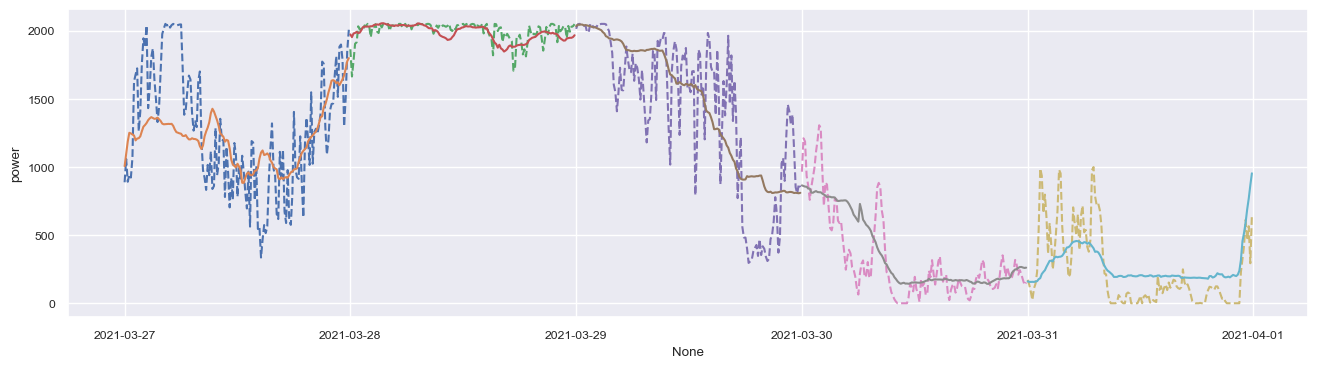

In [70]:
fig, ax = plt.subplots(figsize=(16,4))
for row in results.itertuples():
    sns.lineplot(data=row.y_test, x=row.y_test.index, y=row.y_test.power, linestyle='--', estimator=None)
    sns.lineplot(data=row.y_pred, x=row.y_pred.index, y=row.y_pred.power, estimator=None)

In [71]:
cb.fit(y=y, X=X)
cb.save('../models/cb')

Learning rate set to 0.087028
0:	learn: 592.0089123	total: 48.1ms	remaining: 48s
999:	learn: 135.1768244	total: 38.3s	remaining: 0us


<zipfile.ZipFile filename='..\\models\\cb.zip' mode='r'>

#### Update Test

In [1]:
# Assume we're in a new point of time in future
y_observed = df.loc[:'2021-05-31 23:50:00', ['power']]
X_observed = df.loc[:'2021-05-31 23:50:00'].drop('power', axis=1)

NameError: name 'df' is not defined

In [73]:
cb.update(y_observed, X_observed, update_params=False)

RecursiveTabularRegressionForecaster(estimator=<catboost.core.CatBoostRegressor object at 0x000001E6256A7450>)

In [74]:
# True target day-ahead
y_true = df.loc['2021-06-01 00:00:00':'2021-06-01 23:50:00', ['power']]

In [75]:
# Features day-ahead
X_forecast = df.loc['2021-06-01 00:00:00':'2021-06-01 23:50:00'].drop('power', axis=1)

In [76]:
# Predicted target day-ahead
y_forecast = cb.predict(fh, X_forecast)

In [77]:
df_forecast = pd.concat([y_observed.tail(144*3), y_true, y_forecast], axis=1)
df_forecast.columns = ['observed', 'true', 'forecast']

In [ ]:
fig = px.line(df_forecast, labels={'index': '', 'value': 'Power (kW)'})
fig.show(renderer='browser')

In [ ]:
# import matplotlib.pyplot as plt
# from sktime.forecasting.model_evaluation import evaluate
# from sktime.forecasting.naive import NaiveForecaster

# # Dictionary to store RMSE values of each model
# model_rmse_scores = {}

# # Evaluate and store RMSE for each model
# # Naive Forecaster
# # results_naive = evaluate(forecaster=naive, cv=cv, y=y, X=X, strategy='update', scoring=rmse, return_data=True)
# # model_rmse_scores['Naive'] = results_naive.test_MeanSquaredError.mean()

# # Linear Regression
# results_linear = evaluate(forecaster=linear_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['Linear Regression'] = results_linear.test_MeanSquaredError.mean()

# # Lasso Regression
# results_lasso = evaluate(forecaster=lasso_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['Lasso'] = results_lasso.test_MeanSquaredError.mean()

# # KNN Regressor
# results_knn = evaluate(forecaster=knn_pipe, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['KNN'] = results_knn.test_MeanSquaredError.mean()

# # Decision Tree Regressor
# results_tree = evaluate(forecaster=tree, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['Decision Tree'] = results_tree.test_MeanSquaredError.mean()

# # Random Forest Regressor
# results_forest = evaluate(forecaster=forest, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['Random Forest'] = results_forest.test_MeanSquaredError.mean()

# # LightGBM Regressor
# results_lgbm = evaluate(forecaster=lgbm, cv=cv, y=y, X=X, strategy='refit', scoring=rmse, return_data=True)
# model_rmse_scores['LightGBM'] = results_lgbm.test_MeanSquaredError.mean()

# # Convert dictionary to DataFrame for easier plotting
# rmse_df = pd.DataFrame(list(model_rmse_scores.items()), columns=['Model', 'RMSE'])
# rmse_df = rmse_df.sort_values(by='RMSE')  # Sort by RMSE for better readability in plot

# # Plot RMSE scores
# plt.figure(figsize=(10, 6))
# sns.barplot(x='RMSE', y='Model', data=rmse_df, palette="viridis")
# plt.xlabel('Root Mean Squared Error (RMSE)')
# plt.ylabel('Model')
# plt.title('Model Comparison - RMSE')
# plt.show() 


NameError: name 'cv' is not defined